<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos del alumno:

- Alumno: Víctor David Silva
- Cohorte: 14

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

Se configura para usar la GPU para tensorflow en MacOS.

In [47]:
import tensorflow as tf

# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.13.0


In [48]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [49]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input

In [50]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [51]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario



In [52]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [53]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 25

def clean_text(txt):
    txt = txt.lower()    
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    
    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out
        
        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 3497


In [54]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [55]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

In [56]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer

input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 1230
Sentencia de entrada más larga: 8


In [57]:
# Filtramos y entre estos, sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

# Se suma 1 para incluir el token de palabra desconocida
num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) 

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 1203
Sentencia de salida más larga: 9


In [58]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 3497
encoder_input_sequences shape: (3497, 8)
decoder_input_sequences shape: (3497, 9)


In [59]:
from keras.utils import to_categorical
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(3497, 9, 1204)

### 3 - Preparar los embeddings
Utilizar los embeddings de FastText para transformar los tokens de entrada en vectores

In [60]:
import os
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Los embeddings fasttext.pkl ya están descargados


In [61]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [62]:
# Por una cuestion de RAM se utilizarán los embeddings de Fasttext de dimension 300. Instanciamos el embedding
model_embeddings = FasttextEmbeddings()

In [63]:
# Crear la Embedding matrix de las secuencias

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index proviene del tokenizer
nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [64]:
# Dimensión de los embeddings de la secuencia
embedding_matrix.shape

(1230, 300)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [65]:
max_input_len

8

In [66]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

n_units = 128
lstm_dropout = 0.2

# define training encoder
encoder_inputs = Input(shape=(max_input_len))

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, dropout=lstm_dropout, recurrent_dropout=lstm_dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)

encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, dropout=lstm_dropout, recurrent_dropout=lstm_dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 9)]                  0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 8, 300)               369000    ['input_8[0][0]']             
                                                                                                  
 embedding_5 (Embedding)     (None, 9, 128)               154112    ['input_9[0][0]']             
                                                                                            

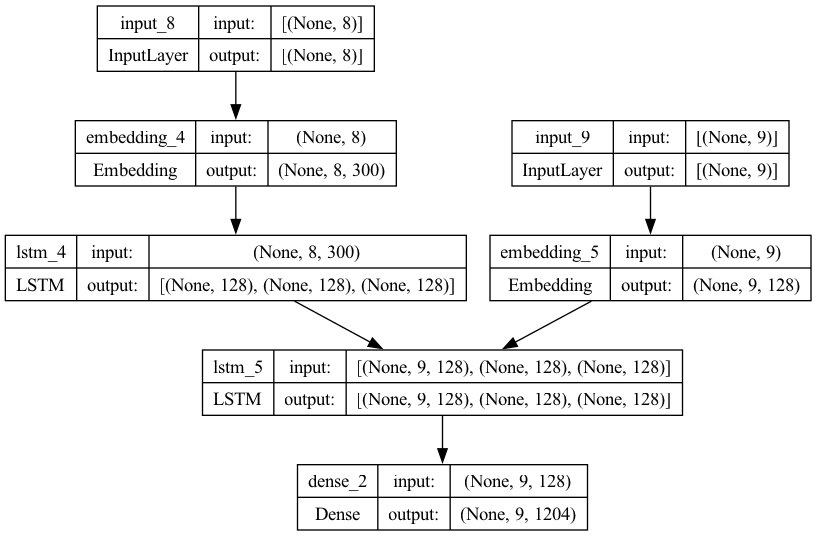

In [67]:
# Modelo completo (encoder+decoder) para poder entrenar
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

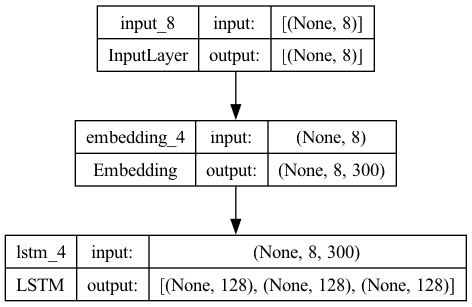

In [68]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

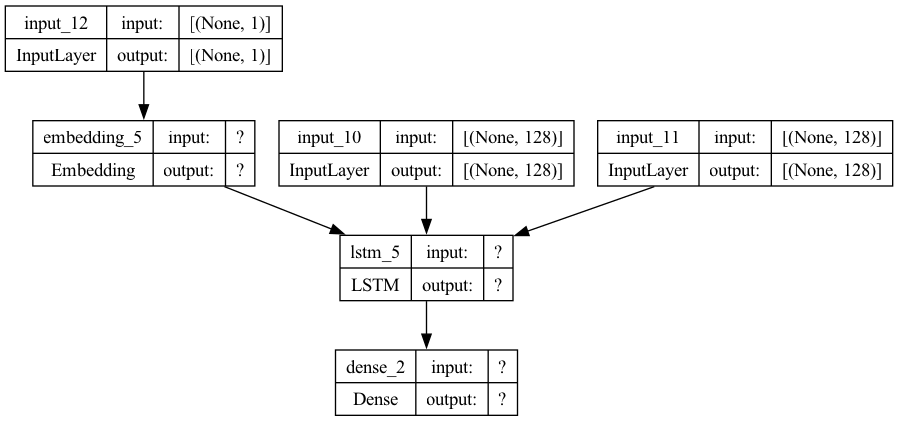

In [69]:
# Modelo solo decoder (para realizar inferencia)

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

Se hace uso de callbacks para mejorar los resultados del entrenamiento. Se agrega EarlyStopping, ReduceLROnPlateau y ModelCheckpoint

In [70]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Detiene el entrenamiento cuando la métrica monitoreada deja de mejorar.
early_stop = EarlyStopping(
    monitor='val_loss',  # métrica a monitorear
    patience=5,          # número de épocas sin mejora antes de detener
    restore_best_weights=True)  # restaurar los pesos del mejor modelo

# Reduce la tasa de aprendizaje cuando la métrica monitoreada deja de mejorar.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # métrica a monitorear
    factor=0.2,          # factor de reducción del learning rate
    patience=3,          # número de épocas sin mejora antes de reducir
    min_lr=1e-6)         # límite inferior del learning rate

# Guarda el mejor modelo durante el entrenamiento.
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',  # ruta donde se guardará el modelo
    monitor='val_loss',        # métrica a monitorear
    save_best_only=True)       # guardar solo el mejor modelo

# Entrenamiento del modelo
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=50, 
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr, checkpoint])

Epoch 1/50


2024-08-25 20:45:41.898611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - ETA: 0s - loss: 3.3736 - accuracy: 0.5060

2024-08-25 20:46:21.813369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 43s 458ms/step - loss: 3.3736 - accuracy: 0.5060 - val_loss: 2.4606 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 2/50


/Users/victordavidsilva/tensorflow-test/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 38s 435ms/step - loss: 2.1320 - accuracy: 0.6161 - val_loss: 2.1512 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 3/50
88/88 [==============================] - 38s 432ms/step - loss: 1.9280 - accuracy: 0.6520 - val_loss: 2.0611 - val_accuracy: 0.6540 - lr: 0.0010
Epoch 4/50
88/88 [==============================] - 38s 435ms/step - loss: 1.7862 - accuracy: 0.6757 - val_loss: 1.9619 - val_accuracy: 0.6770 - lr: 0.0010
Epoch 5/50
88/88 [==============================] - 39s 442ms/step - loss: 1.6534 - accuracy: 0.7041 - val_loss: 1.8974 - val_accuracy: 0.6889 - lr: 0.0010
Epoch 6/50
88/88 [==============================] - 39s 444ms/step - loss: 1.5580 - accuracy: 0.7172 - val_loss: 1.8455 - val_accuracy: 0.6951 - lr: 0.0010
Epoch 7/50
88/88 [==============================] - 39s 448ms/step - loss: 1.4885 - accuracy: 0.7255 - val_loss: 1.8111 - val_accuracy: 0.7016 - lr: 0.0010
Epoch 8/50
88/88 [==============================] - 40s 450ms/step - loss: 

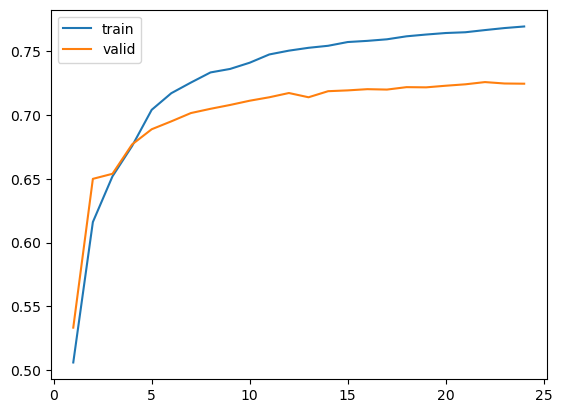

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

Se observa que dieron valores aceptables de accuracy en train y en validation, con sus curvas aumentando en cada epoch.

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [72]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [131]:
def chat_bot(input_string):
    input_string = clean_text(input_string)
    input_seq = input_tokenizer.texts_to_sequences([input_string])
    input_seq = pad_sequences(input_seq, maxlen=max_input_len)

    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentence <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''        
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)


In [134]:
# Inferencia 1
chat_string =  'Hello'
print("Entrada al chat: ", chat_string)
print("Respuesta del bot: ", chat_bot(chat_string))

Entrada al chat:  Hello
Respuesta del bot:  hello how are you


In [135]:
# Inferencia 2
chat_string =  'Hi'
print("Entrada al chat: ", chat_string)
print("Respuesta del bot: ", chat_bot(chat_string))

Entrada al chat:  Hi
Respuesta del bot:  hello how are you


In [136]:
# Inferencia 3
chat_string =  'Tell me about you'
print("Entrada al chat: ", chat_string)
print("Respuesta del bot: ", chat_bot(chat_string))

Entrada al chat:  Tell me about you
Respuesta del bot:  i am a girl


In [137]:
# Inferencia 4
chat_string =  'Be happy'
print("Entrada al chat: ", chat_string)
print("Respuesta del bot: ", chat_bot(chat_string))

Entrada al chat:  Be happy
Respuesta del bot:  i love to read


In [138]:
# Inferencia 5
chat_string =  'Are you happy?'
print("Entrada al chat: ", chat_string)
print("Respuesta del bot: ", chat_bot(chat_string))

Entrada al chat:  Are you happy?
Respuesta del bot:  i am a girl


Se observa que algunas de las inferencias, responden algo coherente. En la primera que se le saluda con "hello", respondiendo con "hello how are you", lo mismo sucede en la segunda que se le pregunta "Hi" y responde con "hello how are you". En el tercer caso se le da como entrada "Tell me about you", respondiendo "i am a girl". En el cuarto caso se le escribe "Be happy" y contesta con "i love to read". Por lo tanto se observa que funciona de manera adecuada, pero tiene el problema de que muchas veces contesta con lo mismo sin importar cual sea la pregunta, como en el caso de preguntas que del tipo "Are you...", donde responde "i am a girl", como se ve en el caso 5.
Se podría mejorar consumiendo todo el dataset o uno más grande en RAM.